In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

2022-10-01 01:53:40.606586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 01:53:40.793651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 01:53:40.793693: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-01 01:53:40.849041: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-01 01:53:41.886641: W tensorflow/stream_executor/platform/de

In [13]:
df = pd.read_json('ETH_USDT-1h-futures.json')
df['label'] = df[4].shift(-1)
df.drop(df[-1:].index,inplace=True)
# train, test = train_test_split(df, test_size=0.2, random_state=8675309, shuffle=False)
X = df[[1,2,3,4,5]]
y = df.label

X_pipeline = make_pipeline(StandardScaler())
y_pipeline = make_pipeline(StandardScaler())
X = X_pipeline.fit_transform(X)
y = y_pipeline.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42,shuffle=False)

params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 8
}


X_train, y_train = pd.DataFrame(X_train),pd.DataFrame(y_train)
def build_timeseries(X_train,y_train):
    X, y = [], []
    for i in range(params["time_steps"], X_train.shape[0]):
        X.append(X_train.iloc[i-params["time_steps"]:i, :])
        y.append(y_train.iloc[i])
    return np.array(X), np.array(y)

X_train,y_train = build_timeseries(X_train, y_train)
X_test, y_test = pd.DataFrame(X_test),pd.DataFrame(y_test)
X_test, y_test = build_timeseries(X_test, y_test)


In [30]:
df = pd.read_json('ETH_USDT-1h-futures.json')
df = df 

,0,1,2,3,4,5
0,1574838000000,146.00,146.00,146.00,146.00,0.010
1,1574841600000,125.03,145.01,125.03,133.00,0.080
2,1574845200000,133.00,133.00,133.00,133.00,0.000
3,1574848800000,142.20,144.52,142.10,142.62,2832.710
4,1574852400000,142.70,146.92,142.22,146.58,9079.800
...,...,...,...,...,...,...
24857,1664323200000,1327.20,1339.96,1327.20,1332.93,250894.507
24858,1664326800000,1332.92,1336.16,1305.00,1310.28,450948.492
24859,1664330400000,1310.28,1312.19,1266.00,1276.21,957240.762
24860,1664334000000,1276.21,1288.00,1275.00,1286.31,294560.355


In [25]:
""" model testing """
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(8,5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

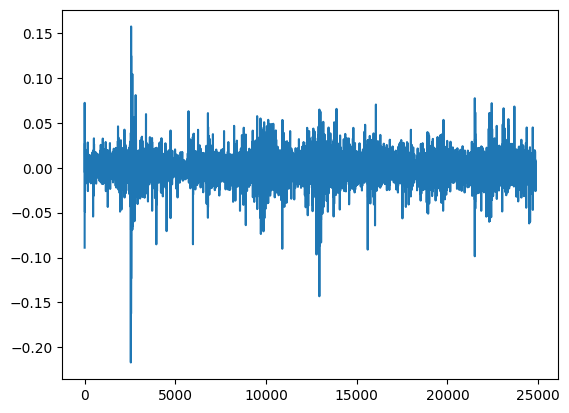

In [27]:
df = df.pct_change()
plt.plot(df[4])
plt.show()

In [22]:
X_test.shape

(4965, 8, 5)

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                        patience=30)
history = model.fit(X_train, y_train, epochs=500, verbose=2, batch_size=20,shuffle=False,validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/500


KeyboardInterrupt: 